In [18]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

In [47]:
import skimage.io
import os
from pathlib import Path
masks_dir = Path(os.path.dirname(ncolor.__file__)).parent.absolute()
masks = skimage.io.imread(os.path.join(masks_dir,'example.png'))

In [51]:
def rescale(T):
    """Rescale array between 0 and 1"""
    T = np.interp(T, (T[:].min(), T[:].max()), (0, 1))
    return T

from skimage import measure 
from scipy.ndimage import find_objects, binary_dilation

def crop_bbx(mask, pad=10, iterations=3, im_pad=0, area_cutoff=0, max_dim=np.inf):
    """Take a label matrix and return a list of bounding boxes identifying clusters of labels.
    
    Parameters
    --------------

    mask: matrix of integer labels
    pad: amount of space in pixels to add around the label (does not extend beyond image edges)
    iterations: number of dilation iterations to merge labels separated by this number of pixel or less
    im_pad: amount of space to subtract off the label matrix edges
    area_cutoff: label clusters below this area in square pixels will be ignored
    max_dim: if a cluster is above this cutoff, quit and return the original image bounding box
    

    Returns
    ---------------

    bbx: list of bounding boxes
    
    """
    bw = binary_dilation(mask>0,iterations=iterations)
    clusters = measure.label(bw)
    regions = measure.regionprops(clusters)
    sz = mask.shape
    ylim = [im_pad,sz[0]-im_pad]
    xlim = [im_pad,sz[1]-im_pad]
    
    bboxes = []
    for props in regions:
        if props.area>area_cutoff:
            bbx = props.bbox 
            y1 = max(bbx[0]-pad,ylim[0])
            x1 = max(bbx[1]-pad,xlim[0])
            y2 = min(bbx[2]+pad,ylim[1])
            x2 = min(bbx[3]+pad,xlim[1])
            w = x2-x1
            h = y2-y1
            
            if w>0 and h>0: 
                if w<max_dim and h<max_dim:
                    bboxes.append([y1,y2,x1,x2])
                    # m = maski[y1:y2,x1:x2].copy()
            else:
                return [[0,ylim,0,xlim]]
    return bboxes

import ncolor.ncolor as ncolor
# import ncolor
bbx = crop_bbx(masks)
y1,y2,x1,x2 = bbx[0]
m = masks[y1:y2,x1:x2]
nc = ncolor.label(m)

combined = np.hstack((rescale(m),rescale(nc)))

cmap = mpl.cm.get_cmap('viridis')
pic = cmap(rescale(combined))
pic[:,:,-1] = combined>0
plt.imshow(pic)
plt.axis('off')
plt.show()
# skimage.io.imsave('/Volumes/DataDrive/ncolor/logo.png',((pic)*255).astype(np.uint8))

AttributeError: module 'ncolor' has no attribute 'label'

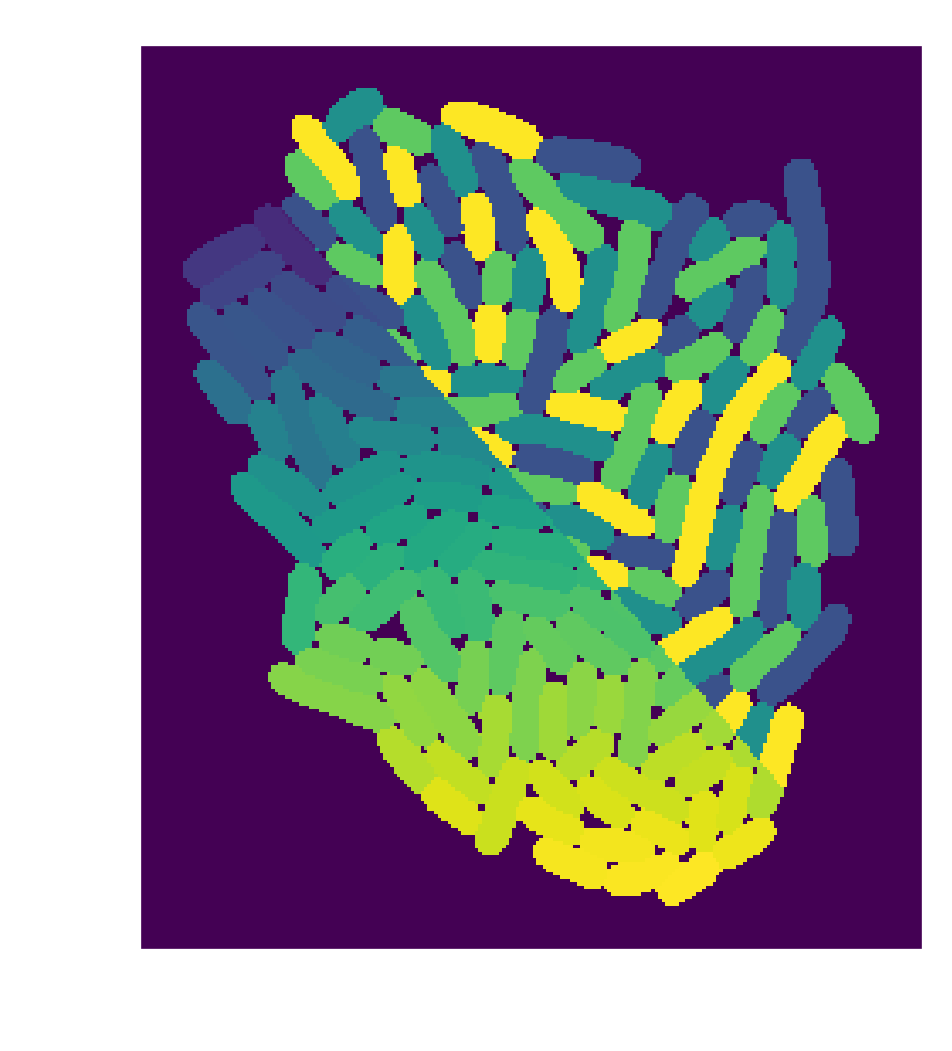

In [49]:
rnc = rescale(nc)
splitview = rescale(m)
sz = m.shape
x, y = np.indices(sz)
mask = y-x*sz[1]/sz[0]>0 # y < x
splitview[mask] = rnc[mask]
plt.imshow(splitview)